# Demonstrating `mobile-env`

`mobile-env` is a simple and open environment for training, testing, and evaluating autonomous coordination
approaches for mobile networks.

* `mobile-env` is written in pure Python and can be installed easily via PyPI
* It allows simulating various scenarios with moving users in mobile networks
* `mobile-env` implements the OpenAI Gym interface such that it can be used with all common frameworks for reinforcement learning
* It supports both centralized, single-agent control and multi-agent control
* It can be configured easily (e.g., adjusting number and movement of users, properties of cells, etc.)
* It is also easy to extend `mobile-env`, e.g., implementing different observations, actions, or reward

As such `mobile-env` is a simple platform to evaluate and compare different coordination approaches in a meaningful way.

---

This demonstration consists of the following steps:

1. Installation and usage of `mobile-env` with a dummy actions
2. Configuration of `mobile-env` and adjustment of the observation space
3. Training a reinforcement learning agent with [`stable-baselines3`](https://github.com/DLR-RM/stable-baselines3)
4. Training multi-agent PPO with [Ray RLlib](https://docs.ray.io/en/latest/rllib.html)


## Step 1: Install and Use `mobile-env` With Dummy Actions

In [6]:
# installation via PyPI
import time
!pip install mobile-env

In [7]:
import gym
import matplotlib.pyplot as plt
import mobile_env


# create a small mobile environment for a single, centralized control agent
env = gym.make("mobile-small-central-v0")

print(f"\nSmall environment with {env.NUM_USERS} users and {env.NUM_STATIONS} cells.")


Small environment with 5 users and 3 cells.


Here, we consider a small scenario with 5 users and 3 cells.
As the users move around, the goal is to connect the users to suitable cells,
ensuring that all users have a good Quality of Experience (QoE).

Connecting to more cells increases data rate for a user but also increases competition for resources
and may decrease rates of other users.
Therefore, a good coordination policy needs to balance this trade-off, depending on available resources and
users' positions.

To measure QoE, the `mobile-env` defaults to a logarithmic utility function of the users' data rate,
where -20 indicates bad QoE and +20 indicates good QoE. This can be easily configured and changed.

To get started, we will use random dummy actions.

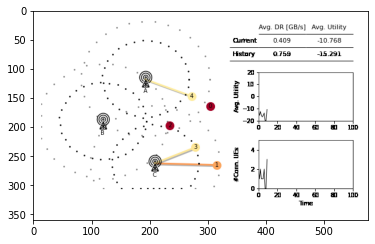

In [8]:
from IPython import display

# TODO: why do UEs move differently everytime?
# isn't there a default seed 0 that should lead to reproducible behavior?

# run the simulation for 10 time steps
done = False
obs = env.reset()
for _ in range(10):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, done, info = env.step(dummy_action)
    # render the environment
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

The rendered environment shows the three cells as cell towers with circles indicating their range.
The five moving users are shown as small circles, where the number indicates the user ID and
the color represents the user's current QoE (red = bad, yellow = ok, green = good).

A line between a user and a cell indicate that the user is connected to the cell.
Again, the color indicates the QoE that's achieved via the connection.
Note that users can connect to multiple cells simultaneously using coordinated multipoint (CoMP).

Before, training a reinforcement learning agent to properly control cell selection,
we will look at some configuration options of `mobile-env`.



## Step 2: Configure `mobile-env`

### Predefined Scenarios

We can choose between one of the [three predefined scenarios](https://mobile-env.readthedocs.io/en/latest/components.html#scenarios):
Small, medium, and large

By default, these are available for either a single, centralized agent (e.g., "mobile-small-central-v0")
or multiple agents (e.g., "mobile-small-ma-v0"), which affects the observations, actions, and reward.

In [9]:
# predefined small scenarios
from mobile_env.scenarios.small import MComSmall

# easy access to the default configuration
MComSmall.default_config()

{'width': 200,
 'height': 200,
 'EP_MAX_TIME': 100,
 'seed': 0,
 'reset_rng_episode': False,
 'arrival': mobile_env.core.arrival.NoDeparture,
 'channel': mobile_env.core.channels.OkumuraHata,
 'scheduler': mobile_env.core.schedules.ResourceFair,
 'movement': mobile_env.core.movement.RandomWaypointMovement,
 'utility': mobile_env.core.utilities.BoundedLogUtility,
 'handler': mobile_env.handlers.central.MComCentralHandler,
 'bs': {'bw': 9000000.0, 'freq': 2500, 'tx': 30, 'height': 50},
 'ue': {'velocity': 1.5, 'snr_tr': 2e-08, 'noise': 1e-09, 'height': 1.5},
 'arrival_params': {'ep_time': 100, 'reset_rng_episode': False},
 'channel_params': {},
 'scheduler_params': {},
 'movement_params': {'width': 200, 'height': 200, 'reset_rng_episode': False},
 'utility_params': {'lower': -20, 'upper': 20, 'coeffs': (10, 0, 10)}}

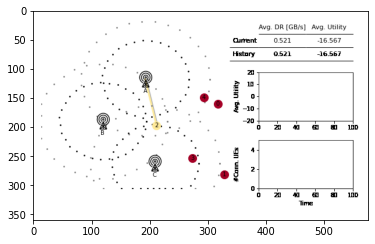

In [10]:
# render the small environment (same as above)
env = gym.make("mobile-small-central-v0")
env.reset()
# random first step
env.step(env.action_space.sample())
plt.imshow(env.render(mode='rgb_array'))

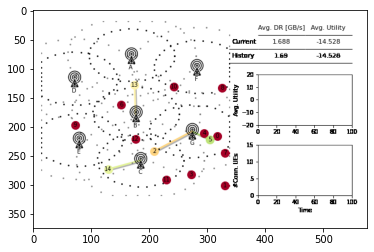

In [11]:
# create and render the medium environment
env = gym.make("mobile-medium-central-v0")
env.reset()
# random first step
env.step(env.action_space.sample())
plt.imshow(env.render(mode='rgb_array'))

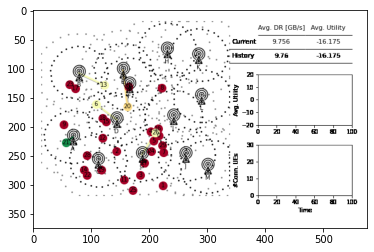

In [12]:
# create and render the large environment
env = gym.make("mobile-large-central-v0")
env.reset()
# random first step
env.step(env.action_space.sample())
plt.imshow(env.render(mode='rgb_array'))

### Custom Scenario

It is also easy to define a custom scenario by subclassing `mobile-env`'s `MComCore` base class.

Here, we create a custom scenario with two cells and three users,
where one user is stationary and the other two users move quickly with 5 m/s.

We also configure the environment to simulate each episode with identical user positions and movement.
By default, users appear and move randomly in each episode.
We also set the episode length to 10 (instead of default 100 steps).

In [15]:
from mobile_env.core.base import MComCore
from mobile_env.core.entities import BaseStation, UserEquipment


class CustomEnv(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            # 10 steps per episode
            "EP_MAX_TIME": 10,
            # identical episodes
            "seed": 42,
            'reset_rng_episode': True,
        })
        # faster user movement
        config["ue"].update({
            "velocity": 5,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=1, pos=(50, 100), **env_config["bs"]),
            BaseStation(bs_id=2, pos=(100, 100), **env_config["bs"])
        ]

        # users
        users = [
            # stationary user --> set velocity to 0
            UserEquipment(ue_id=1, velocity=0, snr_tr=env_config["ue"]["snr_tr"], noise=env_config["ue"]["noise"],
                          height=env_config["ue"]["height"]),
            # two fast moving users with config defaults
            UserEquipment(ue_id=2, **env_config["ue"]),
            UserEquipment(ue_id=3, **env_config["ue"]),
        ]

        super().__init__(stations, users, config)


# init and render the custom scenario
env = CustomEnv()
env.reset()
# random first step
env.step(env.action_space.sample())
plt.imshow(env.render(mode='rgb_array'))
# FIXME: this breaks if I run it multiple times

{'width': 200, 'height': 200, 'EP_MAX_TIME': 10, 'seed': 42, 'reset_rng_episode': True, 'arrival': <class 'mobile_env.core.arrival.NoDeparture'>, 'channel': <class 'mobile_env.core.channels.OkumuraHata'>, 'scheduler': <class 'mobile_env.core.schedules.ResourceFair'>, 'movement': <class 'mobile_env.core.movement.RandomWaypointMovement'>, 'utility': <class 'mobile_env.core.utilities.BoundedLogUtility'>, 'handler': <class 'mobile_env.handlers.central.MComCentralHandler'>, 'bs': {'bw': 9000000.0, 'freq': 2500, 'tx': 30, 'height': 50}, 'ue': {'velocity': 5, 'snr_tr': 2e-08, 'noise': 1e-09, 'height': 1.5}, 'arrival_params': {'ep_time': 100, 'reset_rng_episode': False}, 'channel_params': {}, 'scheduler_params': {}, 'movement_params': {'width': 200, 'height': 200, 'reset_rng_episode': False}, 'utility_params': {'lower': -20, 'upper': 20, 'coeffs': (10, 0, 10)}}


KeyError: 0